# Merge SWOT and S2 ice mask

In [1]:
import pandas as pd
import numpy as np

import rasterio
import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import datetime

## One file test

### Prep SWOT data

In [ ]:
# this file isn't reprojected
# SWOT_df = pd.read_pickle("../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/filtered_SWOT_PIXC.pkl")

# this file had the geolocqual_problem_bits filtering which might be too aggressive for ice
# load in the reprojected & filtered SWOT obs
# SWOT_df = pd.read_csv("../SWOT_reprojected.csv")

# NEW SHINY TESTER

SWOT_df = pd.read_csv("../filtered_SWOT_PIXC_20250719_EPSG32606.csv")

# # column names
# print(SWOT_df.columns)
# # shape
# print(SWOT_df.shape)

In [4]:
print(SWOT_df.columns)

Index(['phase_noise_std', 'dheight', 'class', 'classqual', 'bright_land_flag',
       'ancillary_surface_classification_flag', 'waterfrac',
       'waterfrac_uncert', 'prior_water_prob', 'geolocqual', 'sig0',
       'sig0_uncert', 'sig0_qual', 'crosstrack', 'pixel_area', 'elevation',
       'cycle_number', 'pass_number', 'tile_number', 'time', 'x_utm', 'y_utm'],
      dtype='object')


In [14]:
SWOT_df['time_granule_start'] = SWOT_df['time']

In [6]:
# drop lat lon columns now that we are in UTMs
SWOT_df = SWOT_df.drop(columns=["longitude", "latitude"])

# convert timestamps to datetime objects
# SWOT_df['time_granule_start'] = pd.to_datetime(SWOT_df['time_granule_start'])
SWOT_df['time'] = pd.to_datetime(SWOT_df['time'])

In [8]:
# Create a normalized elevation column based on grouped cycle, pass, and time information

# Confirm elevation is numeric
SWOT_df['elevation'] = pd.to_numeric(SWOT_df['elevation'], errors='coerce')

# Function to return normalized values between 0 and 1
def _group_minmax(series):
    mn = series.min()
    mx = series.max()
    # if values are NaN keep them NaN
    if pd.isna(mn) and pd.isna(mx):
        return pd.Series(np.nan, index=series.index)
    # if constant group (mx == mn), don't normalize and set to NaN (this shouldn't happen tho)
    if mx == mn:
        return pd.Series(np.nan, index=series.index)
    return (series - mn) / (mx - mn)

# Create the normalized elevation
# SWOT_df['elevation_normalized'] = (SWOT_df
#     .groupby(['cycle_number', 'pass_number', 'time_granule_start'])['elevation'] # group by cycle, pass, & time
#     .transform(_group_minmax) # normalize!
# )

In [9]:
SWOT_df.head(5)

,phase_noise_std,dheight,class,classqual,bright_land_flag,ancillary_surface_classification_flag,waterfrac,waterfrac_uncert,prior_water_prob,geolocqual,...,crosstrack,pixel_area,elevation,cycle_number,pass_number,tile_number,time,x_utm,y_utm,elevation_normalized
0,0.723372,-1.592568,1.0,1.0,0.0,1.0,-0.032402,0.055103,0.0,4.0,...,-10762.581,1205.7112,1151.6364,35,543,279,2025-07-19 00:37:14.527858,481207.275939,7.627057e+06,0.785377
1,0.498424,-1.597220,1.0,1.0,0.0,1.0,-0.046209,0.047254,0.0,4.0,...,-10762.682,1205.7010,1151.3005,35,543,279,2025-07-19 00:37:14.527858,481182.047102,7.627075e+06,0.785076
2,0.799815,-1.614336,1.0,1.0,0.0,1.0,-0.084535,0.027734,0.0,4.0,...,-10762.782,1205.6908,1152.0831,35,543,279,2025-07-19 00:37:14.527858,481089.215107,7.627140e+06,0.785777
3,0.385984,-1.660628,2.0,2.0,0.0,1.0,-0.054446,0.040483,0.0,4.0,...,-10762.882,1205.6807,1155.5590,35,543,279,2025-07-19 00:37:14.527858,480838.139267,7.627316e+06,0.788891
4,0.620230,-1.665575,2.0,2.0,0.0,1.0,0.037667,0.082421,0.0,4.0,...,-10762.982,1205.6704,1155.2683,35,543,279,2025-07-19 00:37:14.527858,480811.309379,7.627334e+06,0.788630


In [ ]:
# this block is taking forever on the docker
# so we ran it locally ...

# import geopandas as gpd

# # Create gdf with geometry from longitude/latitude
# gdf = gpd.GeoDataFrame(
#     SWOT_df,
#     geometry=gpd.points_from_xy(SWOT_df['longitude'], SWOT_df['latitude']),
#     crs="EPSG:4326"  # this is a close enough realization for now...
# )

# # UTM zone 6N
# gdf_reprojected = gdf.to_crs(epsg=32606)

# # Add reprojected coordinates to a new DataFrame
# SWOT_reprojected_df = SWOT_df.copy()
# SWOT_reprojected_df["x_utm"] = gdf_reprojected.geometry.x
# SWOT_reprojected_df["y_utm"] = gdf_reprojected.geometry.y

### Prep S2 ice mask data

In [ ]:
# list of ones i've looked at
# poly_01_20250719_snow.tif

In [15]:
# ------------ load snow mask data ------------

# filepath
filepath = "../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif"
snowmask_src = rasterio.open(filepath)

# Read band 1
snowmask_20250603 = snowmask_src.read(1)


In [12]:
# %%bash
# # gdalinfo to check metadata
# gdalinfo ../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif
# # CRS is "WGS 84 / UTM zone 6N"

In [13]:
# %%bash
# gdalwarp -r bilinear -overwrite -t_srs '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' ../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif ../../../../shared_space/SWOT_Aufeis/snow_mask/snow_mask_latlon/poly_01_20250719_snow.tif  

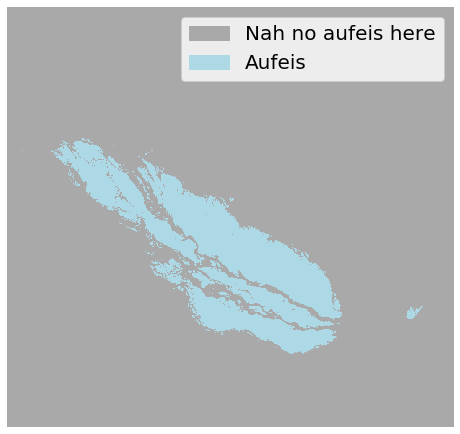

In [11]:
# plot the ice mask!

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Colormap: 0 = dark gray, 1 = light blue
cmap = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(snowmask_20250603, cmap=cmap, norm=norm)
plt.axis('off')
legend_patches = [mpatches.Patch(color='darkgray', label='Nah no aufeis here'),
    mpatches.Patch(color='lightblue', label='Aufeis')]
plt.legend(handles=legend_patches, loc='upper right', frameon=True, fontsize=20)
plt.show()

## Single file join

### Match in time

In [16]:
# Extract the S2 ice mask date

# get just the filename
filename = os.path.basename(filepath)
# Extract the YYYYMMDD part
date_str = filename.split("_")[2]  

# Convert to datetime.date
icemask_date = datetime.strptime(date_str, "%Y%m%d").date()
icemask_date

datetime.date(2025, 7, 19)

In [17]:
# filter to the correct date
SWOT_df_20250719 = SWOT_df[SWOT_df['time_granule_start'].dt.date == icemask_date]


In [17]:
# SWOT_df_20250719

In [18]:
from rasterio.transform import rowcol

# get raster transform & shape
transform = snowmask_src.transform
height, width = snowmask_20250603.shape

# make a safe copy to avoid SettingWithCopyWarning
SWOT_df_20250719 = SWOT_df_20250719.copy()

# compute row/col for each SWOT pixel
rows, cols = rowcol(transform,
                    SWOT_df_20250719["x_utm"].values,
                    SWOT_df_20250719["y_utm"].values)

# convert to numpy arrays
rows = np.array(rows, dtype=int)
cols = np.array(cols, dtype=int)

# mask of what pixels are in bounds of the raster
in_bounds = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)

# create an array of NaNs then fill in-bounds values from the raster
ice_vals = np.full(len(rows), np.nan, dtype=float)
if in_bounds.any():
    ice_vals[in_bounds] = snowmask_20250603[rows[in_bounds], cols[in_bounds]]

In [19]:
# join ice mask to the SWOT dataframe
SWOT_df_20250719["ice_mask"] = ice_vals  # NaN = outside raster; otherwise 0 or 1

# only keep SWOT pixels inside the raster
SWOT_df_20250719_overlap = SWOT_df_20250719[~SWOT_df_20250719["ice_mask"].isna()].copy()

# convert ice_mask to integer 0/1
SWOT_df_20250719_overlap["ice_mask"] = SWOT_df_20250719_overlap["ice_mask"].astype(int)

# some quick checks
print("All points (before spatial filter):", len(SWOT_df_20250719))
print("Points overlapping raster footprint:", len(SWOT_df_20250719_overlap))
SWOT_df_20250719_overlap.head()

All points (before spatial filter): 760452
Points overlapping raster footprint: 0


,phase_noise_std,dheight,class,classqual,bright_land_flag,ancillary_surface_classification_flag,waterfrac,waterfrac_uncert,prior_water_prob,geolocqual,...,elevation,cycle_number,pass_number,tile_number,time,x_utm,y_utm,elevation_normalized,time_granule_start,ice_mask


In [20]:
# look at counts
ice_count = (SWOT_df_20250719_overlap['ice_mask'] == 1).sum()
no_ice_count = (SWOT_df_20250719_overlap['ice_mask'] == 0).sum()

print("Aufeis (1):", ice_count)
print("Nah nah nope (0):", no_ice_count)

Aufeis (1): 1993
Nah nah nope (0): 22036


In [20]:
# save as a csv

output_csv = "../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_SWOT_icemask.csv"

SWOT_df_20250719_overlap.to_csv(output_csv, index=False)

# HERE IS HOW TO PLOT SWOT & RASTER TOGETHER

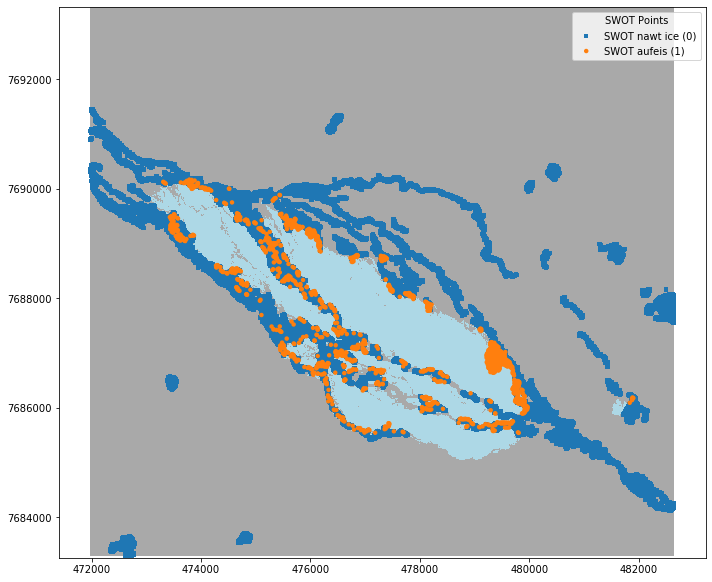

In [36]:
# plot to check!
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


# colormap and norm (0 = dark gray, 1 = light blue)
cmap = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Mask NaNs so they plot transparent
raster_to_plot = np.ma.masked_invalid(snowmask_20250603)

# compute georeferenced extent: (minx, miny, maxx, maxy)
height, width = snowmask_20250603.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(
    height, width, snowmask_src.transform
)
extent = (minx, maxx, miny, maxy)

# ok actual plotting now
fig, ax = plt.subplots(figsize=(10, 10))

# plot ice mask raster
im = ax.imshow(
    raster_to_plot, cmap=cmap, norm=norm,
    extent=extent, origin='upper', interpolation='nearest'
)

# plot SWOT points
df = SWOT_df_20250719_overlap
mask_ice = df['ice_mask'] == 1
mask_noice = df['ice_mask'] == 0
mask_out = df['ice_mask'].isna()

point_handles = []  # store legend handles


h_noice = ax.scatter(df.loc[mask_noice, 'x_utm'], df.loc[mask_noice, 'y_utm'],
                     s=20, marker='s', label='SWOT nawt ice (0)', edgecolor='none')
point_handles.append(h_noice)

if mask_ice.any():
    h_ice = ax.scatter(
        df.loc[mask_ice, 'x_utm'], df.loc[mask_ice, 'y_utm'],
        s=20, marker='o', label='SWOT aufeis (1)', edgecolor='none'
    )
    point_handles.append(h_ice)

# Legend for SWOT points ONLY
ax.legend(handles=point_handles, loc='upper right', title="SWOT Points")

# Labels & aspect
# ax.set_xlabel('UTM X')
# ax.set_ylabel('UTM Y')
ax.set_aspect('equal', adjustable='box')

# plt.title("Snow mask (0 = dark gray, 1 = light blue) with SWOT points")
plt.tight_layout()
plt.show()


In [37]:
SWOT_df_20250719_overlap.head(5)

,phase_noise_std,waterfrac,geolocqual,sig0,sig0_uncert,crosstrack,elevation,cycle_number,pass_number,tile_number,time_granule_start,source_file,x_utm,y_utm,elevation_normalized,ice_mask
822949,0.036112,0.191685,0,2.505438,1.320719,-50125.832,418.125891,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472381.972125,7.683366e+06,0.298034,0
822950,0.030306,0.513329,0,7.407903,3.619110,-50137.773,417.951496,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472374.526080,7.683372e+06,0.297732,0
822951,0.022068,0.705059,0,12.915502,6.201205,-50149.730,417.760237,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472367.298752,7.683377e+06,0.297400,0
822952,0.030209,0.866819,0,14.735769,7.054668,-50161.574,417.536564,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472360.491691,7.683381e+06,0.297013,0
822953,0.036771,0.244385,0,4.446941,2.231380,-50173.420,417.470195,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472351.654988,7.683388e+06,0.296898,0


In [49]:
SWOT_df_20250719_overlap.iloc[24000]['source_file']

'SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_20250719T003725_PID0_01.nc'